# Install Modules

In [66]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tensorflow.keras.preprocessing.image import load_img

warnings.filterwarnings("ignore")


## Load the Dataset

In [67]:
path = 'crop_part1'

In [72]:
images, ages, genders = [], [], []

for filename in tqdm(os.listdir(path)):
    imgs = os.path.join(path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    images.append(imgs)
    ages.append(age)
    genders.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

100%|██████████| 9780/9780 [00:00<00:00, 425265.85it/s]


In [75]:
df = pd.DataFrame({'image': images, 'age': ages, 'gender': genders})

In [77]:
gender_map = {0: 'Male', 1: 'Female'}

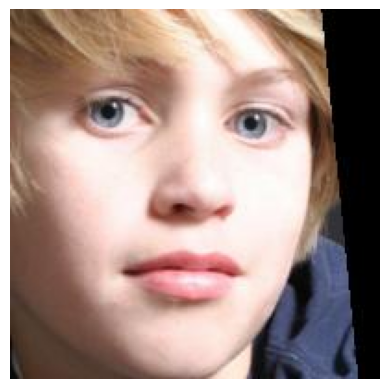

In [78]:
sample_img = Image.open(df.loc[10, 'image'])
plt.axis('off')
plt.imshow(sample_img)
plt.show()

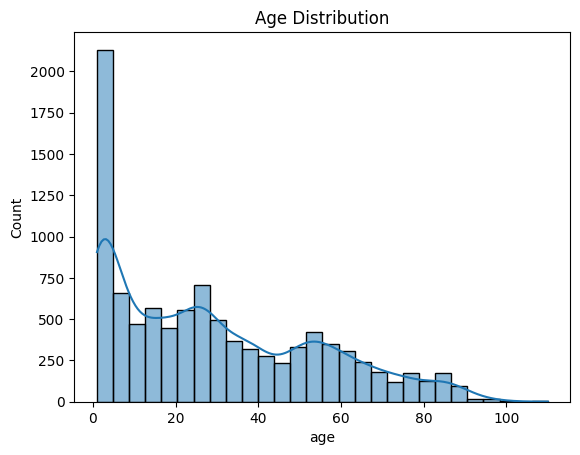

In [79]:
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()



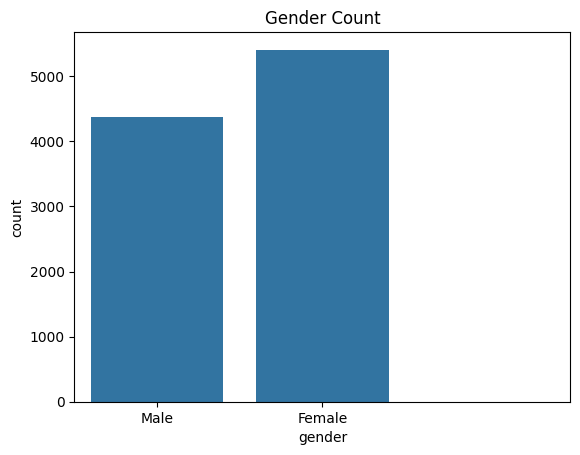

In [80]:

sns.countplot(x='gender', data=df)
plt.xticks([0, 1], labels=["Male", "Female"])
plt.title("Gender Count")
plt.show()

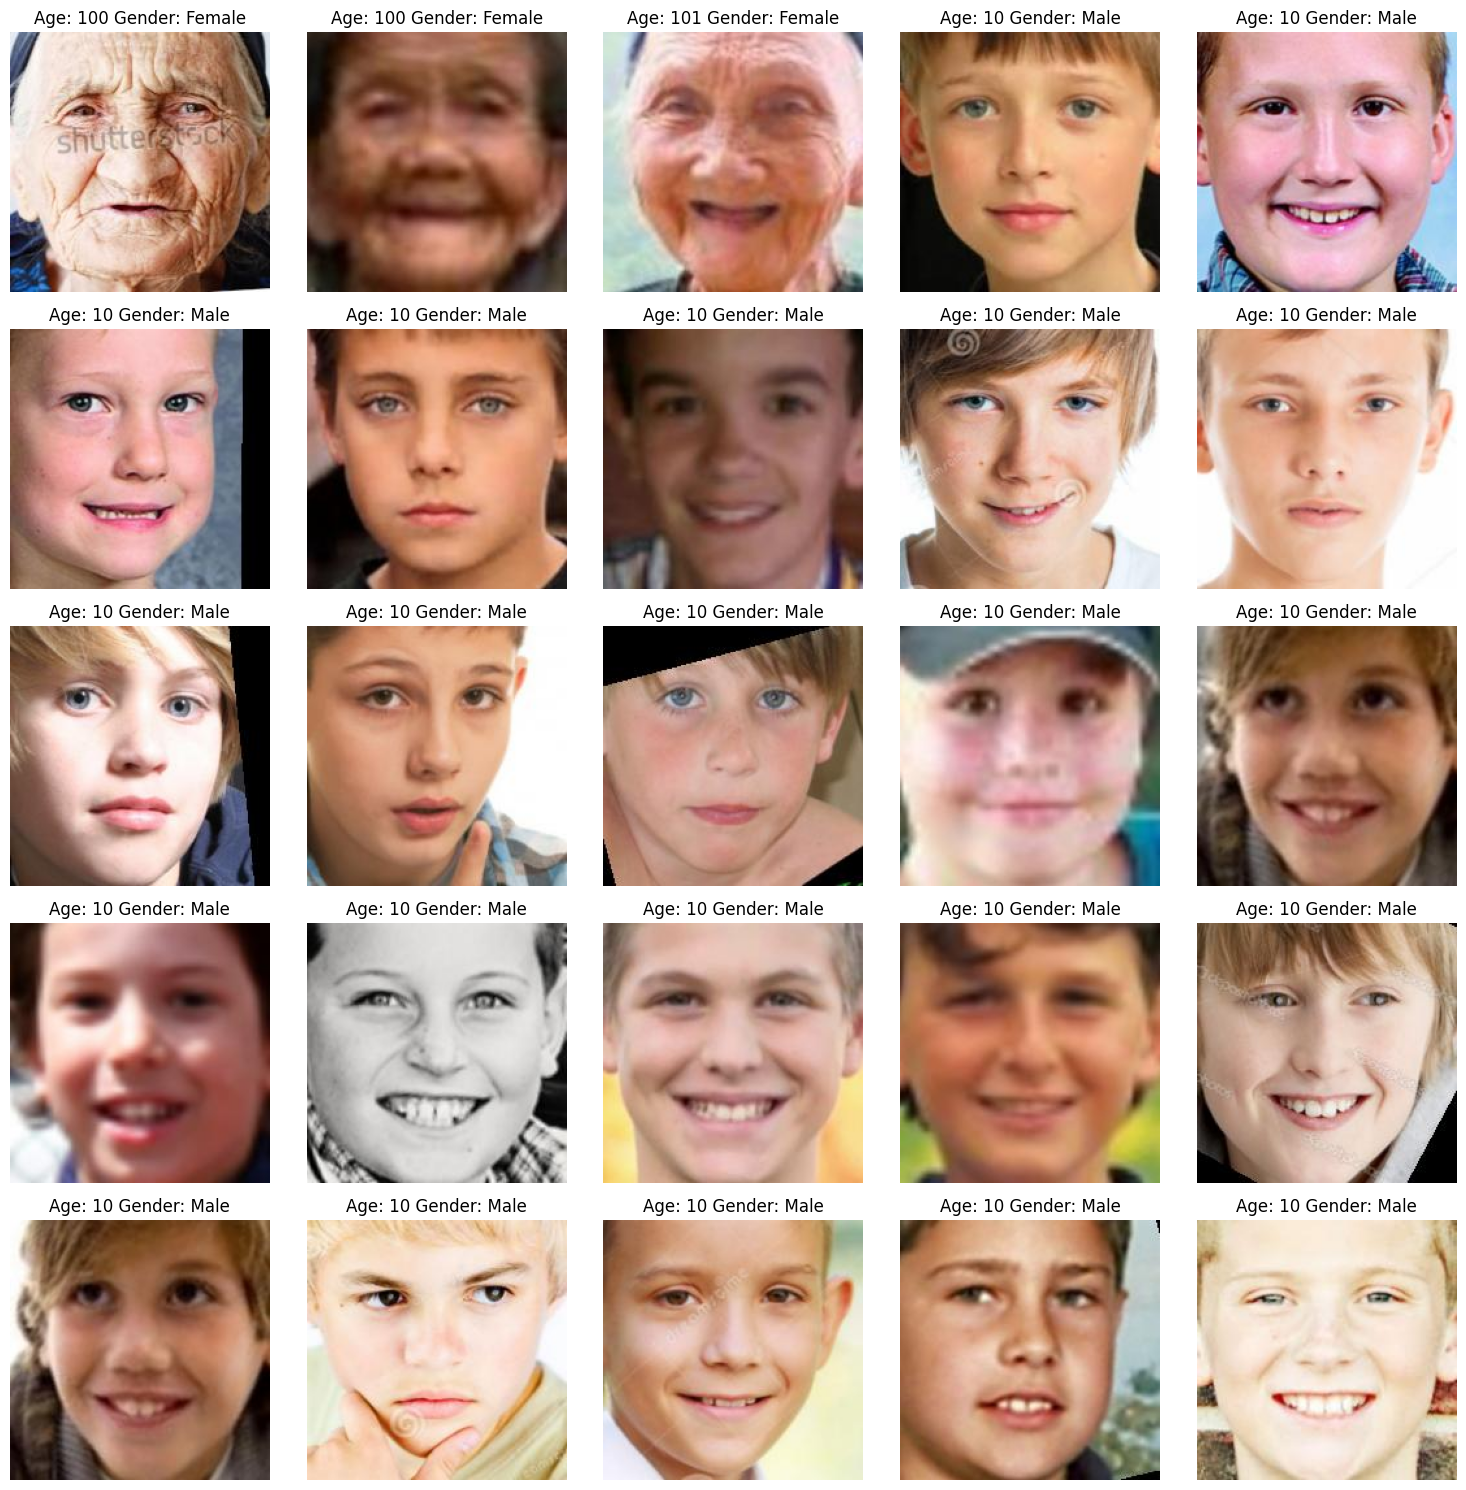

In [85]:
plt.figure(figsize=(15, 15))
for i, row in enumerate(df.iloc[:25].itertuples(index=False)):
    plt.subplot(5, 5, i + 1)
    img = np.array(load_img(row.image))
    plt.imshow(img)
    plt.title(f"Age: {row.age} Gender: {gender_map[row.gender]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Train Test Split

In [86]:
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_ages, val_ages = train_test_split(
    images, ages, test_size=0.2, random_state=42
)

In [95]:
class AgeDataset(Dataset):
    def __init__(self,image_paths,age_labels,transform=None):
        self.image_paths = image_paths
        self.age_labels = age_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        age = torch.tensor(self.age_labels[idx], dtype=torch.float32)
        return image,age

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

In [97]:
train_dataset = AgeDataset(train_imgs,train_ages,transform)
val_dataset = AgeDataset(val_imgs,val_ages,transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

## Model

In [ ]:
class AgePredictorResNet(nn.Module):
    def __init__(self):
        super(AgePredictorResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.base_model(x)

## Validation

In [99]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, ages in val_loader:
            images, ages = images.to("cpu"), ages.to("cpu").unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs,ages)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)


## Training

In [ ]:
model = AgePredictorResNet().to("cpu")
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
best_loss = float("inf")
best_model_path = None
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, ages in progress_bar:
        images, ages = images.to("cpu"), ages.to("cpu").unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,ages)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)

    val_loss = validate(model,val_loader,criterion)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        if best_model_path:
            os.remove(best_model_path)
        os.makedirs("checkpoints",exist_ok=True)
        best_model_path = f"checkpoints/best-epoch-{epoch+1}-loss-{best_loss:.4f}.pt"
        torch.save(model.state_dict(),best_model_path)
        print(f"Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")


## Result

In [ ]:
plt.figure(figsize=(8, 5))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss_history, 'b', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
import cv2
import torch
from PIL import Image

model = AgePredictorResNet().to("cpu")
model.load_state_dict(torch.load('checkpoints\\best-epoch-1-loss-12.3253.pt'))
model.eval() 

image_path = 'PXL_20240204_141148247-01.jpeg'
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_pil = Image.fromarray(image_rgb).convert('L')
image_tensor = transform(image_pil).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor) 

predicted_age = output.item() 

print(f"Predicted Age: {predicted_age:.2f}")


Predicted Age: 28.18
